In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Change to correct working directory
os.chdir('C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming')

# Check working directory
os.getcwd()

'C:\\Users\\xmste\\OneDrive\\Documents\\Systems Biology\\Year 2\\Scientific Programming'

# Load and explore squirrel dataset
In this section, the squirrel dataset is loaded and various aspects of it are explored.

In [3]:
# Read dataset
squirrels_raw = pd.read_csv('nyc_squirrels.csv')

In [4]:
# Get other activities that are not NaN
pd.set_option('display.max_rows', None) # display all columns

other_activities_notnan = squirrels_raw["Other Activities"][squirrels_raw["Other Activities"].notnull()]

From the entries in Other Activities, it can be seen that squirrels 144 and 2041 are dead. Thus, these squirrels are removed from the dataset.

In [5]:
# Remove dead squirrels from data
squirrels = squirrels_raw.drop([144, 2041])
squirrels.reset_index(drop=True, inplace=True)

# TODO: get data of dead squirrels automatically (so by selecting squirrels that have 'dead' in Other Activities column
# TODO: drop squirrels by unique squirrel ID and not index

In [6]:
## Check if removing dead squirrels was succesful

# Check by seeing if dead squirrels still pop up in 'other activities' that are not NaN
other_activities_notnan_live = squirrels["Other Activities"][squirrels["Other Activities"].notnull()]
# print(other_activities_notnan_live)

# Check by printing shapes of original and cleaned data
print(squirrels_raw.shape)
print(squirrels.shape)

(3023, 31)
(3021, 31)


To know whether foraging behavior is interesting and useable to look at, it is important to know how many squirrels were actually seen foraging, to know if there is enough data available for foraging squirrels.

In [7]:
# Get number of foraging squirrels
squirrels.Foraging.value_counts()

False    1586
True     1435
Name: Foraging, dtype: int64

The same has to be done for other variables, such as checking how many squirrels of every type there are and how many are approaching humans. 

In [8]:
# Get number of squirrels per fur color
squirrels['Primary Fur Color'].value_counts()

Gray        2472
Cinnamon     391
Black        103
Name: Primary Fur Color, dtype: int64

In [9]:
# Get number of approaching squirrels
squirrels['Approaches'].value_counts()

False    2843
True      178
Name: Approaches, dtype: int64

In [10]:
# Get number of squirrels per age
squirrels['Age'].value_counts()

Adult       2566
Juvenile     330
?              4
Name: Age, dtype: int64

In [11]:
# Get number of gray squirrels that are approaching humans
squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']

# Calculate proportion of gray squirrels that approached people
squirrels_gray['Approaches'].value_counts().loc[True] / squirrels_gray['Approaches'].value_counts().loc[False]

0.05370843989769821

In [12]:
# Get number of cinnamon squirrels that are approaching humans
squirrels_cinnamon = squirrels.loc[squirrels['Primary Fur Color'] == 'Cinnamon']

# Calculate proportion of gray squirrels that approached people
squirrels_cinnamon['Approaches'].value_counts().loc[True] / squirrels_cinnamon['Approaches'].value_counts().loc[False]

0.12680115273775217

In [13]:
# Get number of black squirrels that are approaching humans
squirrels_black = squirrels.loc[squirrels['Primary Fur Color'] == 'Black']

# Calculate proportion of gray squirrels that approached people
squirrels_black['Approaches'].value_counts().loc[True] / squirrels_black['Approaches'].value_counts().loc[False]

0.061855670103092786

In [14]:
# Get column names
squirrels.columns

Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')

# Map squirrel locations
In this section, the location of squirrels can be mapped. This can be done for all squirrels or for various subsets of squirrels (e.g. only squirrels that are black, foraging, or something else).

## Map based on hectares into which park has been divided

In [15]:
# TODO: look into dot size (does it now really give a good representation of distribution of squirrels?) 
# TODO: heatmap?

def plot_positions(squirrel_data):
    
    # Get number of squirrels per hectare
    squirrels_per_hectare = squirrel_data['Hectare'].value_counts()
    
    # Create figure
    plt.figure(figsize=(5,10))

    # Loop through hectares and plot dot relative to number of squirrels in that hectare
    # x-positions are saved by their ASCII value

    for hectare, n_squirrels in squirrels_per_hectare.items():
        y_coord = int(hectare[:2])
        x_coord = ord(hectare[2:])
        plt.scatter(x_coord, y_coord, color='blue', s=n_squirrels)
        
    plt.xticks([65, 66, 67, 68, 69, 70, 71, 72, 73], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'])
    plt.show()

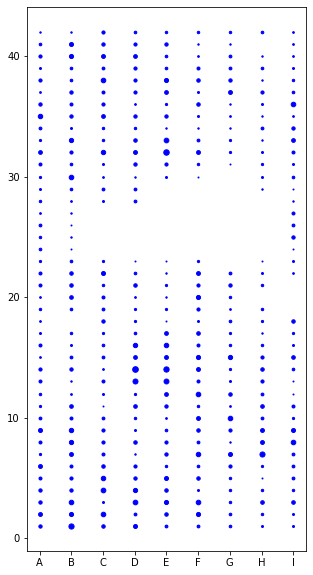

In [16]:
## Examples

# Plot positions of all squirrels
plot_positions(squirrels)

# Plot positions of all approaching gray squirrels
# squirrels_gray = squirrels.loc[squirrels['Primary Fur Color'] == 'Gray']
# plot_positions(squirrels_gray.loc[squirrels_gray['Approaches'] == True])

# Plot positions of all foraging squirrels
# plot_positions(squirrels.loc[squirrels['Foraging'] == True])

# Park dataset

In [17]:
# Load park data
park = pd.read_csv('hectare_data.csv')

# Isolation forest

In [18]:
# Select data to be used in isolation forest
squirrels_isolation = squirrels.drop(['X', 'Y', 'Unique Squirrel ID', 'Date', 'Hectare Squirrel Number',
                                      'Highlight Fur Color',
                                      'Combination of Primary and Highlight Color', 
                                      'Color notes', 'Above Ground Sighter Measurement', 
                                      'Specific Location', 'Other Activities', 'Other Interactions',
                                      'Lat/Long'], axis=1)

# Remove NaNs (only in Age column)


## TODO: make sense of one hot encoder
# Encode data with one hot encoder
squirrels_encoded = OneHotEncoder().fit_transform(squirrels_isolation)
data_hot_encoded = pd.DataFrame(squirrels_encoded, index=squirrels_isolation.index)

# Label encoder
le = LabelEncoder()
squirrels_encoded = squirrels_isolation.apply(lambda col: le.fit_transform(col))    

# Split data into training and test sets
# X_train, X_test = train_test_split(squirrels_encoded, test_size = 0.2, random_state = 20)
# X_train = np.asarray(X_train)
# X_test = np.asarray(X_test)

# Isolation forest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples='auto', random_state=rng)
# clf.fit(X_train)
# y_pred_train = clf.predict(X_train)
# y_pred_test = clf.predict(X_test)

clf.fit(squirrels_encoded)
pred = clf.predict(squirrels_encoded)
squirrels['anomaly']=pred
outliers=squirrels.loc[squirrels['anomaly']==-1]
outlier_index=list(outliers.index)
print(squirrels['anomaly'].value_counts())

 1    2148
-1     873
Name: anomaly, dtype: int64


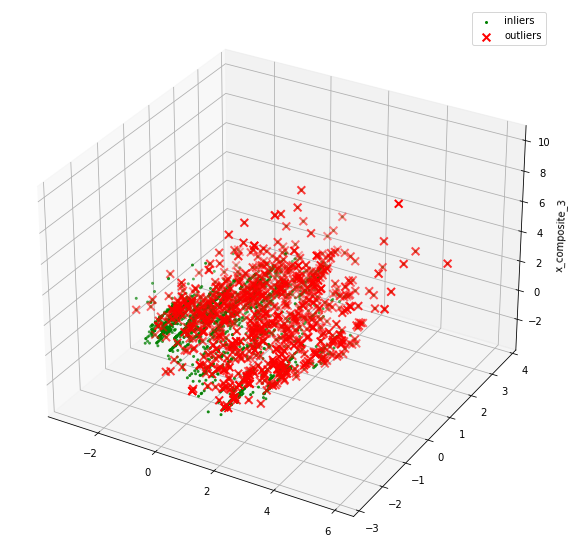

In [19]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions

scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(squirrels_encoded)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [20]:
# Get explained variance per principal component
pca.explained_variance_ratio_

array([0.11247606, 0.08927091, 0.07210666])

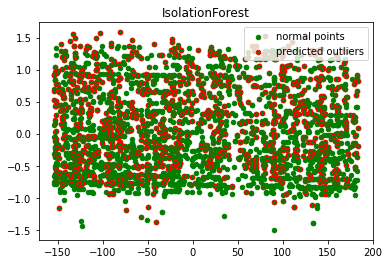

In [21]:
pca = PCA(2)
pca.fit(squirrels_encoded)
res=pd.DataFrame(pca.transform(squirrels_encoded))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

# Color PCA plot by different variables
So instead of outlier_index get list of indices for other variables and color by that

In [ ]:
pca = PCA(2)
pca.fit(squirrels_encoded)
res=pd.DataFrame(pca.transform(squirrels_encoded))
Z = np.array(res)
plt.title("IsolationForest")
# plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

# Unsupervised random forest

https://github.com/ireis/unsupervised-random-forest/blob/master/notebooks/anomaly_detection_example.ipynb\
https://pypi.org/project/URF/

In [22]:
# Select data to be used in isolation forest
squirrels_isolation = squirrels.drop(['X', 'Y', 'Unique Squirrel ID', 'Date', 'Hectare Squirrel Number',
                                      'Highlight Fur Color',
                                      'Combination of Primary and Highlight Color', 
                                      'Color notes', 'Above Ground Sighter Measurement', 
                                      'Specific Location', 'Other Activities', 'Other Interactions',
                                      'Lat/Long'], axis=1)

# Remove NaNs (only in Age column)


## TODO: make sense of one hot encoder
# Encode data with one hot encoder
# squirrels_encoded = OneHotEncoder().fit_transform(squirrels_isolation)
# ohe = OneHotEncoder()
# array_hot_encoded = ohe.fit_transform(squirrels_isolation)
# data_hot_encoded = pd.DataFrame(array_hot_encoded, index=squirrels_isolation.index)

# Label encoder
le = LabelEncoder()
squirrels_encoded = squirrels_isolation.apply(lambda col: le.fit_transform(col))    

# Split data into training and test sets
X_train, X_test = train_test_split(squirrels_encoded, test_size = 0.2, random_state = 20)

# Unsupervised random forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train)
predictions = rf.predict(X_test)

TypeError: fit() missing 1 required positional argument: 'y'

# Stuffs to try
- Color PCA by different variables to see if those are grouped
- Use date: check for differences between weekdays and weekend and maybe holidays
- Use park data: maybe map rainy/cloudy days vs sunny days or color dots on map by business
- Try to get URF working
- Try to get one-hot encoding working
- Find out what random state in isolation forest is and maybe that can be adjusted?
- Mapping: look at dot size, maybe adjust, heat map?

dit is een push